# Gender Face Detection Model

<img src="prediction_example.png" alt="Example Image" width="500"/>


- I chose this small but high quality dataset https://www.kaggle.com/datasets/trainingdatapro/gender-detection-and-classification-image-dataset to create a pretrained model using transfer learning to predict gender. I did this largely due to the processing speed problems and data set quality issues with the emotion classifier model.

- This model is effective at close to 85% accuracy on validation data. There does seem to be a slight issue with Recall on female images, which we will need to address by both adjusting the images and fine-tuning the model.


### Install Necessary Libraries

In [1]:
#!pip install tensorflow-hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast, RandomWidth, RandomHeight, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16,  MobileNetV2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [35]:
print(tf.__version__)

2.16.1


### Load Data and Set Parameters

In [3]:
data_dir = r"C:\Users\rshaw\Desktop\EC Utbildning - Data Science\Kurs 7 - Deep Learning\Kunskapkontroll2-ComputerVision\Emotion_Detection_CNN\Gender_Detection_CNN"
train_dir = os.path.join(data_dir, "train")
validation_dir = os.path.join(data_dir, "validation")

# Parameters
picture_size = 224  # MobileNetV2 expects 224x224 input size
batch_size = 32 # Reduced batch size from 128 to 64 to 32 to increase number of propagations and increase gradient noise and thus boost model performance
epochs = 20 
no_of_classes = 2
gender_labels = ['man', 'woman']

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(picture_size, picture_size),
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=123
)

full_val_set = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(picture_size, picture_size),
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=123
)

class_names = train_set.class_names
val_batches = tf.data.experimental.cardinality(full_val_set).numpy()

# Split the full validation set into validation and test sets (33% each)
test_set = full_val_set.take(val_batches // 3)
val_set = full_val_set.skip(val_batches // 3)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_set).numpy()}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_set).numpy()}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_set).numpy()}")

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 220 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Number of training batches: 7
Number of validation batches: 2
Number of test batches: 1


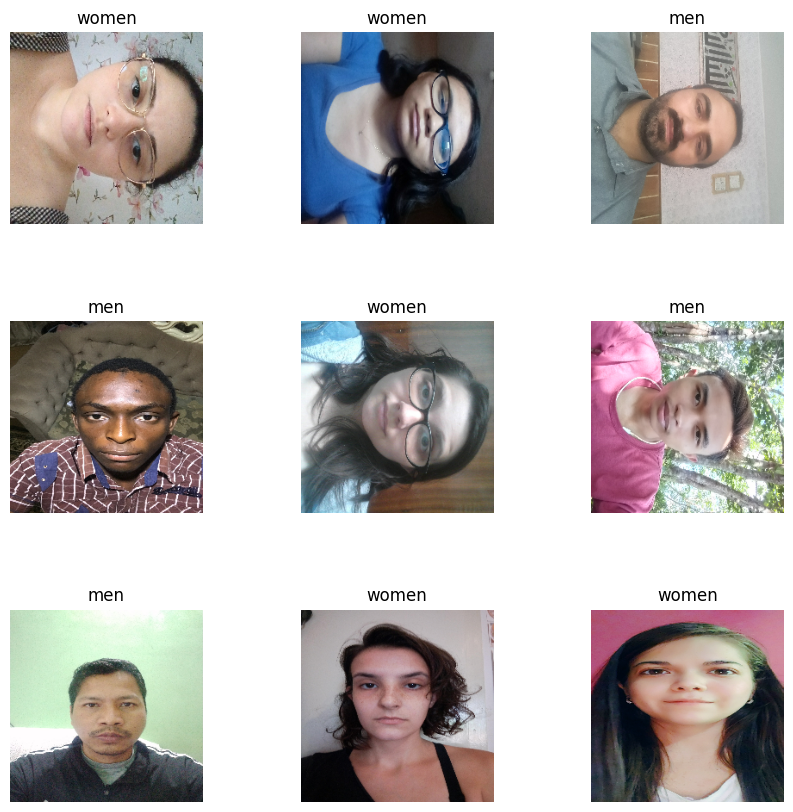

In [4]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for images, labels in train_set.take(1):
  for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
class_names = os.listdir(data_dir)
class_counts = {}
 
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    num_samples = len(os.listdir(class_dir))
    class_counts[class_name] = num_samples
 
print("Class Counts:", class_counts)

Class Counts: {'train': 2, 'validation': 2}


In [6]:
val_images = []
val_labels = []

for images, labels in full_val_set:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Split the dataset into validation and test sets (67% validation, 33% test)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size=0.33, random_state=123)

val_set = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_set = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

class_counts = {"train": {}, "validation": {}, "test": {}}
class_names = os.listdir(train_dir)

for class_name in class_names:
    train_class_dir = os.path.join(train_dir, class_name)
    train_num_samples = len(os.listdir(train_class_dir))
    class_counts["train"][class_name] = train_num_samples

    validation_class_dir = os.path.join(validation_dir, class_name)
    validation_num_samples = len(os.listdir(validation_class_dir))
    class_counts["validation"][class_name] = validation_num_samples

for images, labels in test_set.unbatch():
    label = labels.numpy()
    class_name = gender_labels[label]
    if class_name in class_counts["test"]:
        class_counts["test"][class_name] += 1
    else:
        class_counts["test"][class_name] = 1

print(f"Train dataset size: {tf.data.experimental.cardinality(train_set).numpy()}")
print(f"Validation dataset size: {tf.data.experimental.cardinality(val_set).numpy()}")
print(f"Test dataset size: {tf.data.experimental.cardinality(test_set).numpy()}")
print("Class counts:")
print(class_counts)

Train dataset size: 7
Validation dataset size: 2
Test dataset size: 1
Class counts:
{'train': {'men': 110, 'women': 110}, 'validation': {'men': 40, 'women': 40}, 'test': {'woman': 14, 'man': 13}}


In [7]:
num_original_images = sum([len(files) for r, d, files in os.walk(train_dir)])
steps_per_epoch = num_original_images // batch_size
total_images_seen = steps_per_epoch * batch_size * epochs

print(f"Total number of images seen by the model (including augmented versions): {total_images_seen}")
print(f"Number of original images: {num_original_images}")
print(f"Number of augmented versions seen per original image: {total_images_seen // num_original_images}")

Total number of images seen by the model (including augmented versions): 3840
Number of original images: 220
Number of augmented versions seen per original image: 17


### Build Model Architecture

In [36]:
#Here we add augmentation to help the model generalize better and rescaling to normalize the pixel values for some stable training
model = Sequential()
model.add(Input(shape=(picture_size, picture_size, 3)))

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
    Rescaling(1./127.5, offset=-1)
])
model.add(data_augmentation)

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(picture_size, picture_size, 3)) #MobileNetTV2 w over 2million parameters extracts high-level features from the images
base_model.trainable = False  
model.add(base_model)
model.add(GlobalAveragePooling2D()) # reduces model size and overfitting by reducing feature map to one value
model.add(BatchNormalization())
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Single neuron with sigmoid activation for binary classification
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │        61,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,331,185 (8.89 MB)

 Trainable params: 70,545 (275.57 KB)

 Non-trainable params: 2,260,640 (8.62 MB)

### Model Configuration

In [10]:
opt = Adam(learning_rate=0.001) # Overfitting so reduced Learning Rate from 0.01 to 0.001, given it can help stabilize training and improve generalization.
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0000001)
callbacks_list = [early_stopping, reduce_learningrate]

### Model Training

In [11]:
# Training
history = model.fit(train_set, 
                    epochs=epochs, 
                    validation_data=val_set, 
                    #callbacks=callbacks_list, 
                    verbose=True
                    )

# Save the final model
model.save('final_gender_model_pre_trained.keras')

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 947ms/step - accuracy: 0.5059 - loss: 0.7894 - val_accuracy: 0.6226 - val_loss: 0.6002
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 720ms/step - accuracy: 0.5671 - loss: 0.7481 - val_accuracy: 0.7170 - val_loss: 0.5669
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 680ms/step - accuracy: 0.6624 - loss: 0.6717 - val_accuracy: 0.7170 - val_loss: 0.5280
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 678ms/step - accuracy: 0.6852 - loss: 0.5846 - val_accuracy: 0.7736 - val_loss: 0.5035
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 666ms/step - accuracy: 0.7409 - loss: 0.5434 - val_accuracy: 0.7736 - val_loss: 0.4877
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 685ms/step - accuracy: 0.7135 - loss: 0.5271 - val_accuracy: 0.7925 - val_loss: 0.4652
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step - accuracy: 0.7363 - loss: 0.5494 - val_accuracy: 0.8113 - val_loss: 0.4524
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 680ms/step - accuracy: 0.7198 - loss: 0.5688 - val_accuracy: 0.7547 - val_loss

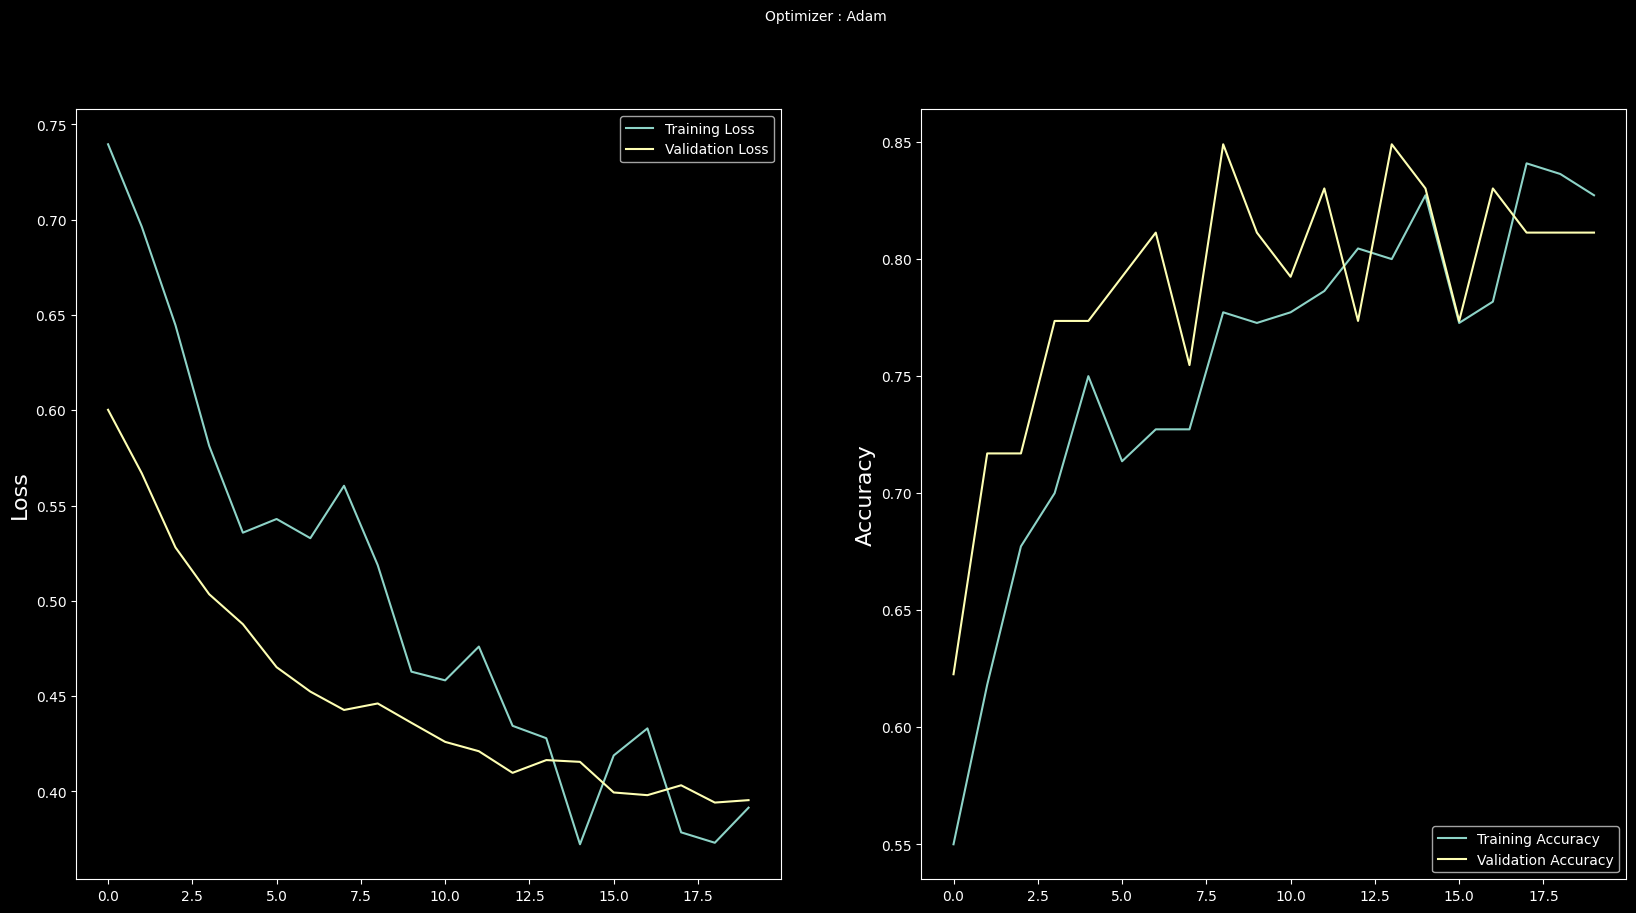

In [13]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

- The model showed significant improvements in both training and validation accuracy during the first few epochs, indicating effective early learning and adaptation. 
  The highest validation accuracy was 84.91% in Epoch 9. 

- Despite continued training, the model's performance stabilized, with some fluctuations in validation accuracy, suggesting the need for possible further fine-tuning or adjustments.

### Model Analysis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
Number of correct predictions: 16
Number of incorrect predictions: 4


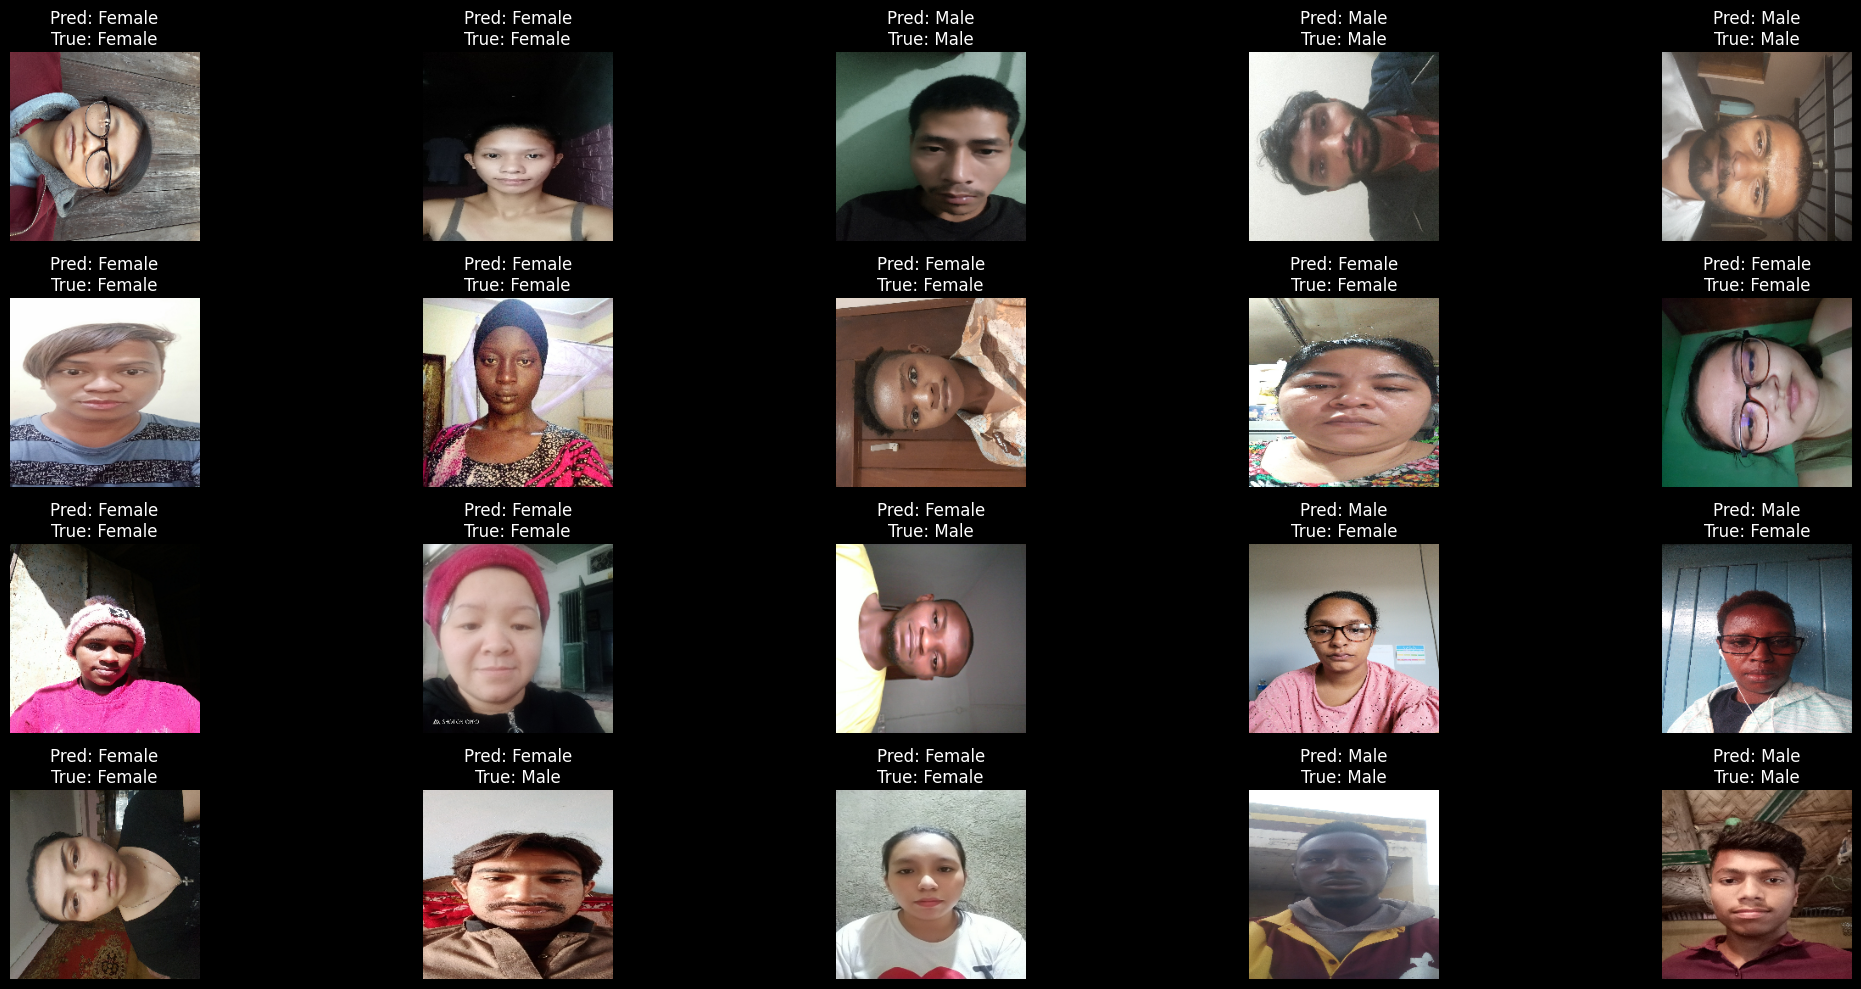

In [18]:
# Here we take a quick snapshot of the model's accuracy on a small subset of the test data.
num_images_to_display = 20
predictions = model.predict(test_set)
f = lambda x: "Female" if x > 0.5 else "Male"
gender_predictions = [f(prediction) for prediction in predictions]

true_labels = np.concatenate([label.numpy() for _, label in test_set])
true_genders = ["Female" if label == 1 else "Male" for label in true_labels]
correct_predictions = sum([pred == true for pred, true in zip(gender_predictions[:num_images_to_display], true_genders[:num_images_to_display])])
incorrect_predictions = num_images_to_display - correct_predictions
print(f"Number of correct predictions: {correct_predictions}")
print(f"Number of incorrect predictions: {incorrect_predictions}")

plt.figure(figsize=(20, 10))

for batch in test_set.take(1):
    images, labels = batch
    for i in range(min(num_images_to_display, len(images))):
        plt.subplot(4, 5, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {gender_predictions[i]}\nTrue: {true_genders[i]}")
        plt.axis("off")
        plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()


- These image classifications show about 80% accuracy on a sample of the test set, indicating good generalization. To understand this better we look at a classification report and confusion matrix.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


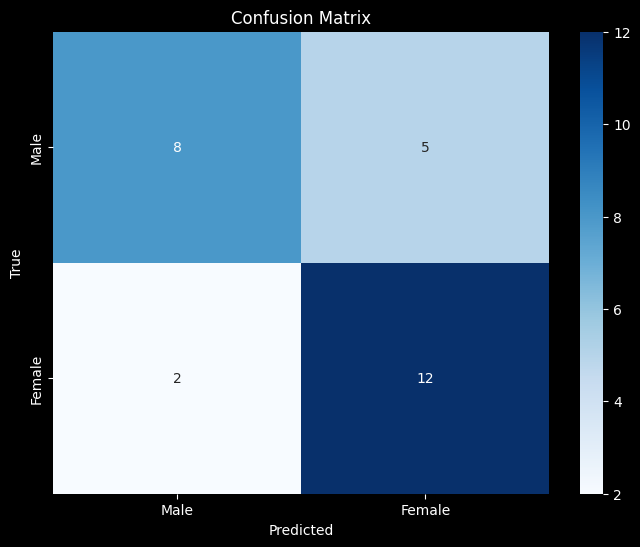

Classification Report:
              precision    recall  f1-score   support

      Female       0.71      0.86      0.77        14
        Male       0.80      0.62      0.70        13

    accuracy                           0.74        27
   macro avg       0.75      0.74      0.73        27
weighted avg       0.75      0.74      0.74        27



In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

predictions = model.predict(test_set)
predicted_classes = (predictions > 0.5).astype("int32")
true_labels = np.concatenate([label.numpy() for _, label in test_set])

cm = confusion_matrix(true_genders, gender_predictions, labels=["Male", "Female"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(true_genders, gender_predictions, labels=["Female", "Male"]))

* On the test data the accuracy lowers slighly from 81 to 74% but the model is still generalizing quite well.
* The model performs better in identifying Males (higher recall and F1-score) than Females.
* The trade-off between precision and recall is evident, especially in the Female class where recall is significantly lower than precision. So we set the threshold in the inference script to 0.35.

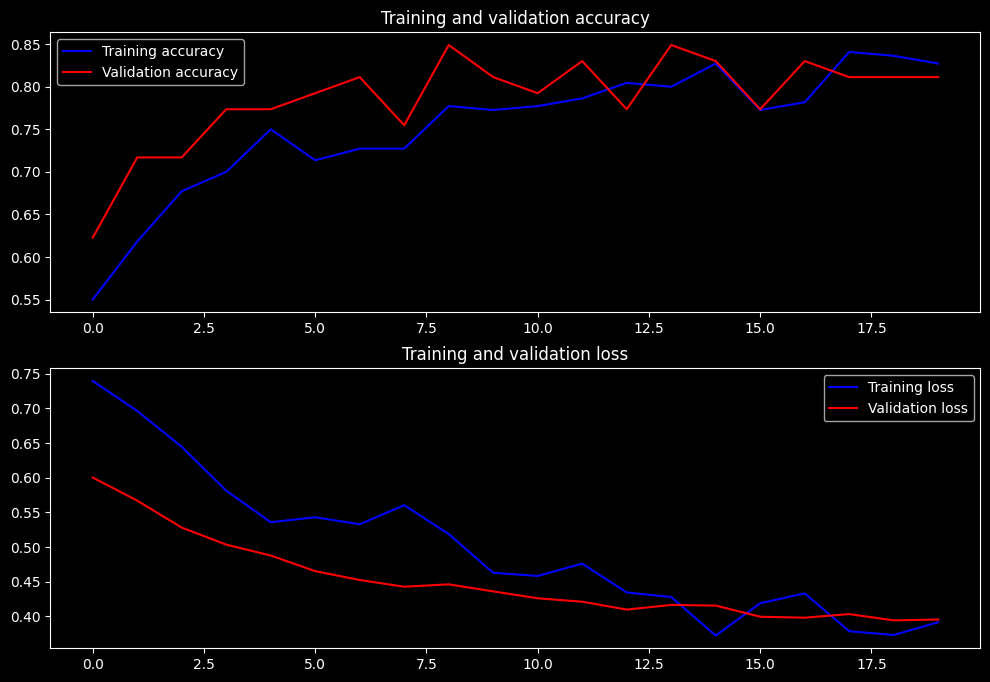

In [23]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)

* Both training and validation loss decrease and stabilize at low values, and both training and validation accuracy are high and close to each other.
* The model is generalizing well to the validation data.

### Model Fine-Tuning

In [24]:
base_model.trainable = True
print(len(base_model.layers))

154


In [25]:
FINE_TUNING_START = 140  # we freeze first 140 layers and fine-tune the rest.

for layer in base_model.layers[:FINE_TUNING_START]:
  layer.trainable = False

In [26]:
model.compile(
    optimizer=RMSprop(learning_rate=0.001/25), # we reduce the learning rate by 25%
    loss='binary_crossentropy',
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)
callbacks_list = [early_stopping, reduce_learningrate]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (32, 224, 224, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (32, 7, 7, 1280)       │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (32, 1280)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 1280)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,041,281 (3.97 MB)

 Non-trainable params: 1,217,984 (4.65 MB)

- Now we go from a little over 70,000 trainable parameters to just over 1 million. This should help improve the feature extraction.

### Retrain model

In [27]:
fine_tune_epochs = epochs * 2 
history_fine = model.fit(
    train_set,
    validation_data=val_set,
    epochs=fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks_list
)

# Save the final model
model.save('gender_model_pre_trained_tuned.keras')

Epoch 20/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7822 - loss: 0.4586 - val_accuracy: 0.8302 - val_loss: 0.3702 - learning_rate: 4.0000e-05
Epoch 21/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 790ms/step - accuracy: 0.8239 - loss: 0.4017 - val_accuracy: 0.8113 - val_loss: 0.3714 - learning_rate: 4.0000e-05
Epoch 22/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 745ms/step - accuracy: 0.8279 - loss: 0.3751 - val_accuracy: 0.8302 - val_loss: 0.3652 - learning_rate: 4.0000e-05
Epoch 23/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 735ms/step - accuracy: 0.8218 - loss: 0.3994 - val_accuracy: 0.8302 - val_loss: 0.3776 - learning_rate: 4.0000e-05
Epoch 24/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 744ms/step - accuracy: 0.8555 - loss: 0.3501 - val_accuracy: 0.8302 - val_loss: 0.3512 - learning_rate: 4.0000e-05
Epoch 25/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 733ms/step - accuracy: 0.8164 - loss: 0.3555 - val_accuracy: 0.8302 - val_loss: 0.3711 - learning_rate: 4.0000e-05
Epoch 26/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 756ms/step - accuracy: 0.8305 - 

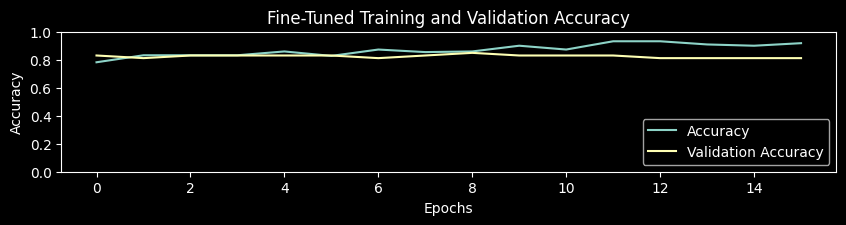

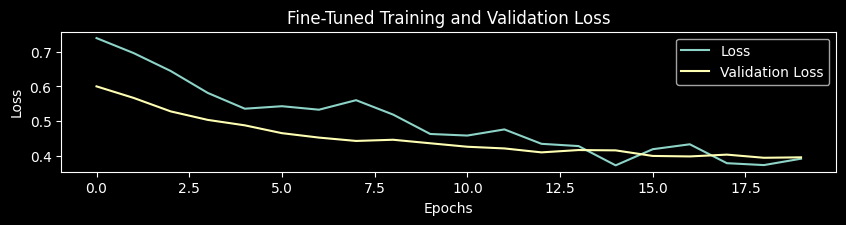

In [30]:
accuracy = history_fine.history["accuracy"]
val_accuracy = history_fine.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(10,4))
ax = plt.subplot(2, 1, 1)
ax.plot(accuracy, label="Accuracy")
ax.plot(val_accuracy, label="Validation Accuracy")
ax.legend(loc="lower right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Fine-Tuned Training and Validation Accuracy")
ax.set_ylim([0,1])
plt.show()

plt.figure(figsize=(22,4))
ax = plt.subplot(2, 2, 1)
ax.plot(loss, label="Loss")
ax.plot(val_loss, label="Validation Loss")
ax.legend(loc="upper right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Fine-Tuned Training and Validation Loss")
plt.show()

- The fine-tuned model showed significant improvements in both training and validation accuracy during the early epochs of fine-tuning, showing effective adaptation and further learning from the additional training data.

- However, the model's performance fluctuated in validation accuracy, with occasional decreases, suggesting the need for potential further adjustments or learning rate modifications. The highest validation accuracy was 84.91% in Epoch 28. This was exactly the same as the original model performance.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
Number of correct predictions: 16
Number of incorrect predictions: 4


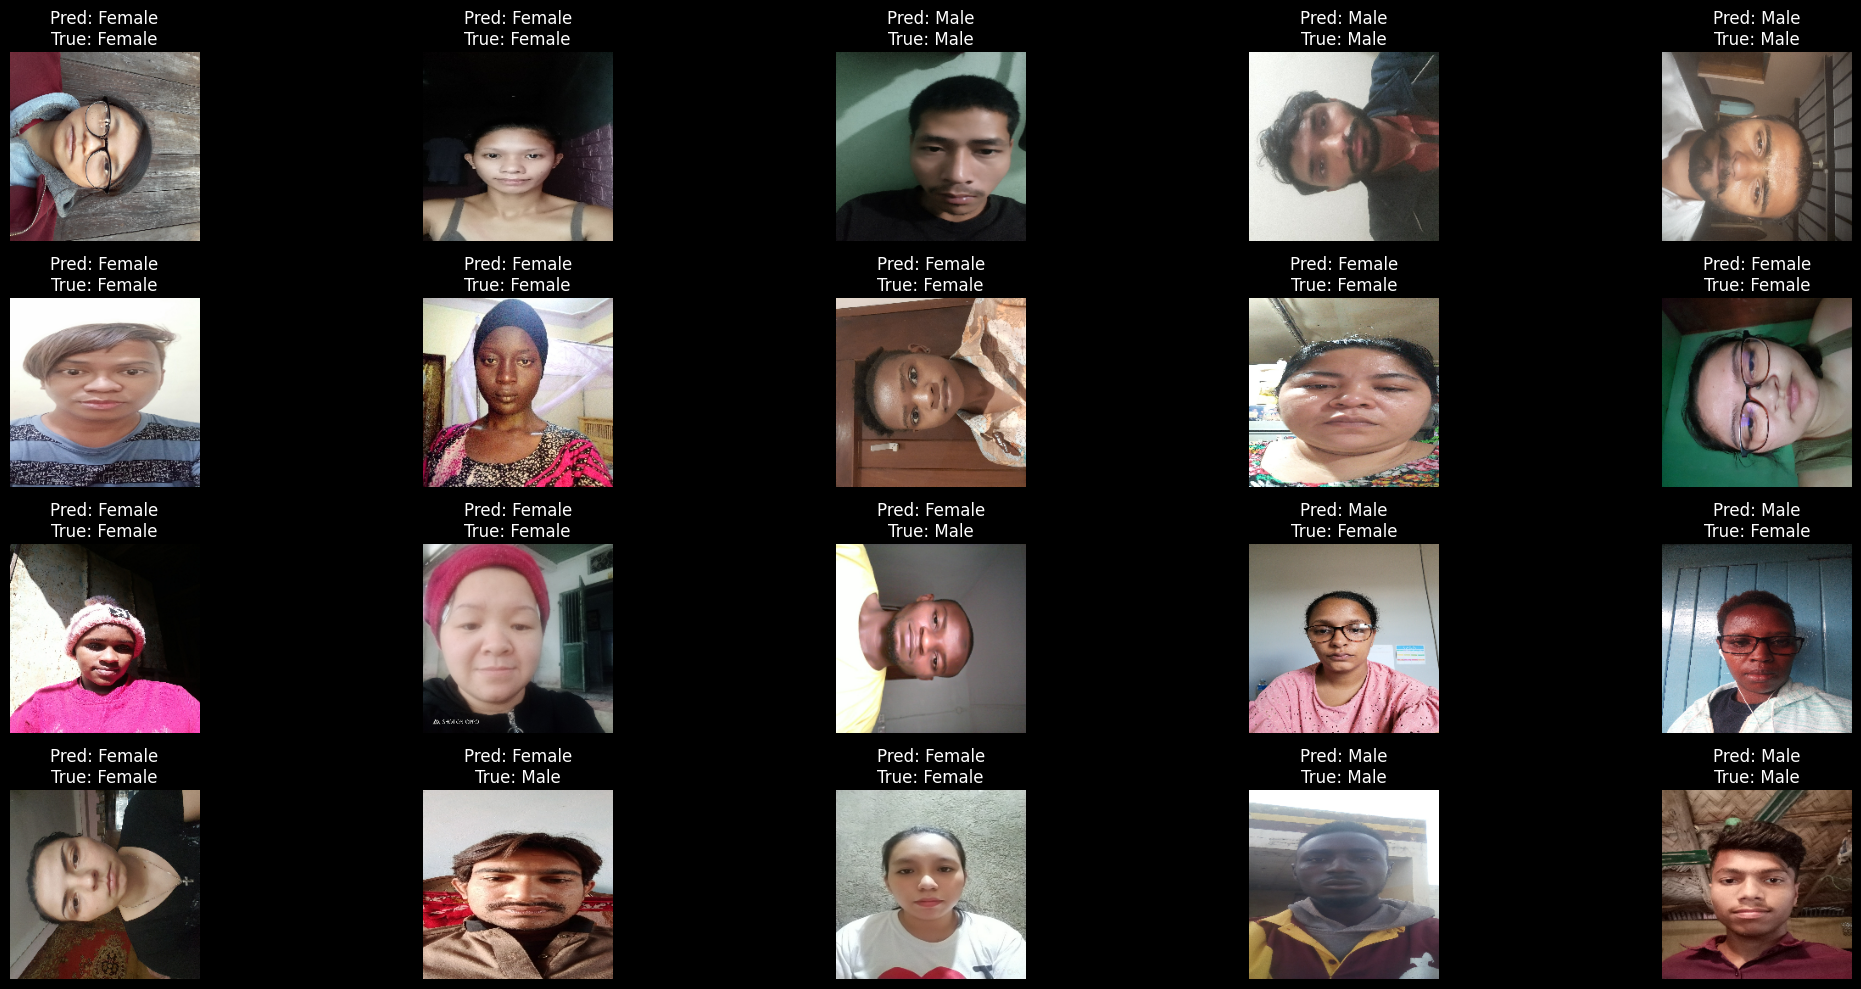

In [34]:
num_images_to_display = 20
predictions = model.predict(test_set)
f = lambda x: "Female" if x > 0.5 else "Male"
gender_predictions = [f(prediction) for prediction in predictions]
true_labels = np.concatenate([label.numpy() for _, label in test_set])
true_genders = ["Female" if label == 1 else "Male" for label in true_labels]

correct_predictions = sum([pred == true for pred, true in zip(gender_predictions[:num_images_to_display], true_genders[:num_images_to_display])])
incorrect_predictions = num_images_to_display - correct_predictions

print(f"Number of correct predictions: {correct_predictions}")
print(f"Number of incorrect predictions: {incorrect_predictions}")

plt.figure(figsize=(20, 10))

for batch in test_set.take(1):
    images, labels = batch
    for i in range(min(num_images_to_display, len(images))):
        plt.subplot(4, 5, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {gender_predictions[i]}\nTrue: {true_genders[i]}")
        plt.axis("off")
        plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


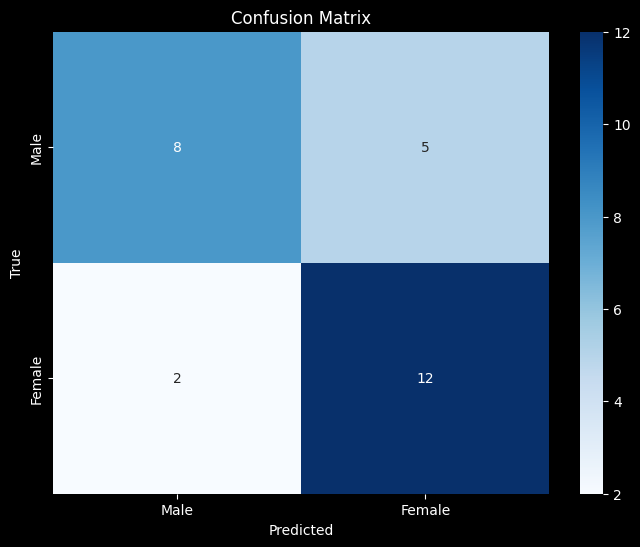

Classification Report:
              precision    recall  f1-score   support

      Female       0.71      0.86      0.77        14
        Male       0.80      0.62      0.70        13

    accuracy                           0.74        27
   macro avg       0.75      0.74      0.73        27
weighted avg       0.75      0.74      0.74        27



In [39]:

predictions = model.predict(test_set)
predicted_classes = ["Female" if prediction > 0.5 else "Male" for prediction in predictions]

# Compute confusion matrix
cm = confusion_matrix(true_genders, gender_predictions, labels=["Male", "Female"])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_genders, gender_predictions, labels=["Female", "Male"]))


## CONCLUSION

- This is a strong model at close to 85% accuracy but fine-tuning does not initially improve the model. We will need to test further.